In [1]:
!pip install tensorflow-gpu
!pip install pycuda
!pip install scikit-cuda

     |████████████████████████████████| 394.3MB 46kB/s 
     |████████████████████████████████| 1.7MB 9.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627847 sha256=ca9cfa5731f369ce6e020d1614e8c5d4268e2d5bbe5ac582e36b54f614f70ded
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.6-py2.py3-none-any.whl size=60643 sha256=b5b2b199bbc6e79793120f47d7c2919a88926ce88f12395716b2fa5fbbc94746
  Stored in directory: /root/.cache/pip/wheels/8c/a6/65/447b9b4fd1d9bde84ad2fea2431a38f69f3fb573476a98ae03
Successfully built pytools
     |████████████████████████████████| 122kB 9.7MB/s 


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

(train_data, train_label) , (test_data, test_label) = tf.keras.datasets.mnist.load_data()
# print(train_label)
# print(test_data)
train_data, train_label = np.array(train_data), np.array(train_label)
test_data, test_label = np.array(test_data), np.array(test_label)
# print(train_data)
train_data784 = np.reshape(train_data, (60000, 784)) 
test_data784 = np.reshape(test_data, (10000, 784))

train_label = np_utils.to_categorical(train_label) 
test_label = np_utils.to_categorical(test_label)

scaler = StandardScaler()
scaler.fit(train_data784)

train_data784_normalized = scaler.transform(train_data784)
test_data784_normalized = scaler.transform(test_data784)
# print(train_data784_normalized[0])


Text(0, 0.5, 'Cumulative explained variance')

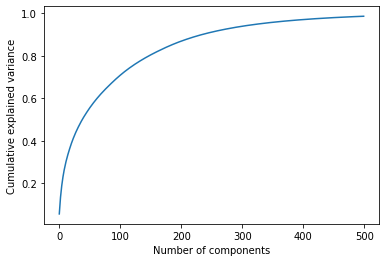

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# import seaborn as sns
%matplotlib inline
pca = PCA(n_components=500)
pca.fit(train_data784_normalized)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
# 60%-70% variance preserved

In [3]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [4]:
pca = PCA(n_components=70)
train_data70 = pca.fit_transform(train_data784_normalized)
test_data70 = pca.transform(test_data784_normalized)
print(train_data70.shape)

(60000, 70)


In [5]:
from keras.models import Sequential
from keras.optimizers import SGD
from time import time
from keras.layers import Dense
from tensorflow.keras.regularizers import l2
"""
train_label = np_utils.to_categorical(train_label) 
test_label = np_utils.to_categorical(test_label)
"""
model_soft = Sequential([
    Dense(512, input_shape=(70,), activation='relu'),
    # GaussianNoise(0.1),
    Dense(512, activation='relu'),
    Dense(10, kernel_regularizer=l2(1e-3), activation='softmax')
])

optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
model_soft.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
t0 = time()
history = model_soft.fit(train_data70, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=2)
t1 = time()
print(t1-t0)

Epoch 1/400
170/170 - 3s - loss: 0.2929 - categorical_accuracy: 0.9220 - val_loss: 0.1497 - val_categorical_accuracy: 0.9643
Epoch 2/400
170/170 - 0s - loss: 0.1373 - categorical_accuracy: 0.9655 - val_loss: 0.1283 - val_categorical_accuracy: 0.9693
Epoch 3/400
170/170 - 0s - loss: 0.0983 - categorical_accuracy: 0.9764 - val_loss: 0.1115 - val_categorical_accuracy: 0.9726
Epoch 4/400
170/170 - 0s - loss: 0.0765 - categorical_accuracy: 0.9821 - val_loss: 0.1018 - val_categorical_accuracy: 0.9742
Epoch 5/400
170/170 - 0s - loss: 0.0731 - categorical_accuracy: 0.9843 - val_loss: 0.1014 - val_categorical_accuracy: 0.9754
Epoch 6/400
170/170 - 0s - loss: 0.0595 - categorical_accuracy: 0.9871 - val_loss: 0.0946 - val_categorical_accuracy: 0.9763
Epoch 7/400
170/170 - 0s - loss: 0.0500 - categorical_accuracy: 0.9897 - val_loss: 0.0960 - val_categorical_accuracy: 0.9774
Epoch 8/400
170/170 - 0s - loss: 0.0436 - categorical_accuracy: 0.9917 - val_loss: 0.0934 - val_categorical_accuracy: 0.9776


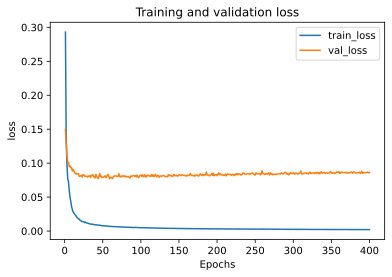

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history, 'loss')

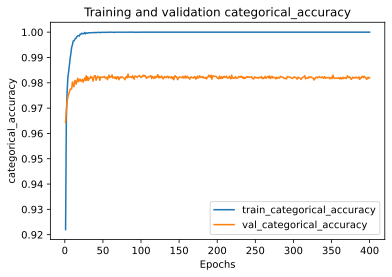

In [7]:
plot_metric(history, 'categorical_accuracy')

In [8]:
print(model_soft.evaluate(test_data70, test_label))

313/313 [==============================] - 1s 2ms/step - loss: 0.0810 - categorical_accuracy: 0.9826
[0.08097135275602341, 0.9825999736785889]


In [10]:
from keras.layers import GaussianNoise
model_soft_noise = Sequential([
    Dense(512, input_shape=(70,), activation='relu'),
    GaussianNoise(0.1),
    Dense(512, activation='relu'),
    Dense(10, kernel_regularizer=l2(1e-3), activation='softmax')
])

optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
model_soft_noise.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
t0 = time()
history_noise = model_soft_noise.fit(train_data70, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=2)
t1 = time()
print(t1-t0)

Epoch 1/400
170/170 - 1s - loss: 0.3027 - categorical_accuracy: 0.9173 - val_loss: 0.1544 - val_categorical_accuracy: 0.9610
Epoch 2/400
170/170 - 0s - loss: 0.1330 - categorical_accuracy: 0.9669 - val_loss: 0.1273 - val_categorical_accuracy: 0.9689
Epoch 3/400
170/170 - 0s - loss: 0.1080 - categorical_accuracy: 0.9744 - val_loss: 0.1079 - val_categorical_accuracy: 0.9743
Epoch 4/400
170/170 - 0s - loss: 0.0842 - categorical_accuracy: 0.9803 - val_loss: 0.1067 - val_categorical_accuracy: 0.9744
Epoch 5/400
170/170 - 0s - loss: 0.0668 - categorical_accuracy: 0.9852 - val_loss: 0.1109 - val_categorical_accuracy: 0.9728
Epoch 6/400
170/170 - 0s - loss: 0.0596 - categorical_accuracy: 0.9878 - val_loss: 0.0958 - val_categorical_accuracy: 0.9772
Epoch 7/400
170/170 - 0s - loss: 0.0487 - categorical_accuracy: 0.9906 - val_loss: 0.0919 - val_categorical_accuracy: 0.9777
Epoch 8/400
170/170 - 0s - loss: 0.0444 - categorical_accuracy: 0.9921 - val_loss: 0.0914 - val_categorical_accuracy: 0.9760


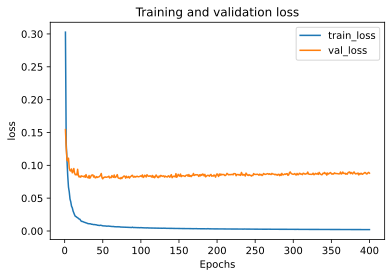

In [14]:
plot_metric(history_noise, 'loss')

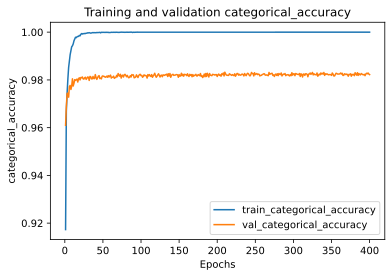

In [15]:
plot_metric(history_noise, 'categorical_accuracy')

In [13]:
print(model_soft_noise.evaluate(test_data70, test_label))

313/313 [==============================] - 1s 2ms/step - loss: 0.0855 - categorical_accuracy: 0.9807
[0.08553893119096756, 0.9807000160217285]


In [18]:
model_svm_noise = Sequential([
    Dense(512, input_shape=(70,), activation='relu'),
    GaussianNoise(0.1),
    Dense(512, activation='relu'),
    Dense(10, activation='linear')
])

optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
model_svm_noise.compile(loss='categorical_hinge', optimizer=optimizer, metrics=['categorical_accuracy'])
t0 = time()
svm_history_noise = model_svm_noise.fit(train_data70, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=2)
t1 = time()
print(t1-t0)

Epoch 1/400
170/170 - 1s - loss: 0.2465 - categorical_accuracy: 0.9111 - val_loss: 0.1020 - val_categorical_accuracy: 0.9594
Epoch 2/400
170/170 - 0s - loss: 0.0961 - categorical_accuracy: 0.9648 - val_loss: 0.0876 - val_categorical_accuracy: 0.9658
Epoch 3/400
170/170 - 0s - loss: 0.0732 - categorical_accuracy: 0.9729 - val_loss: 0.0789 - val_categorical_accuracy: 0.9706
Epoch 4/400
170/170 - 0s - loss: 0.0583 - categorical_accuracy: 0.9784 - val_loss: 0.0792 - val_categorical_accuracy: 0.9717
Epoch 5/400
170/170 - 0s - loss: 0.0468 - categorical_accuracy: 0.9831 - val_loss: 0.0771 - val_categorical_accuracy: 0.9739
Epoch 6/400
170/170 - 0s - loss: 0.0428 - categorical_accuracy: 0.9843 - val_loss: 0.0828 - val_categorical_accuracy: 0.9713
Epoch 7/400
170/170 - 0s - loss: 0.0430 - categorical_accuracy: 0.9850 - val_loss: 0.0852 - val_categorical_accuracy: 0.9724
Epoch 8/400
170/170 - 0s - loss: 0.0330 - categorical_accuracy: 0.9885 - val_loss: 0.1000 - val_categorical_accuracy: 0.9690


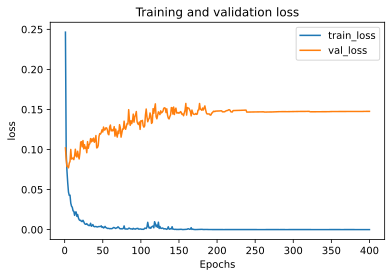

In [19]:
plot_metric(svm_history_noise, 'loss')

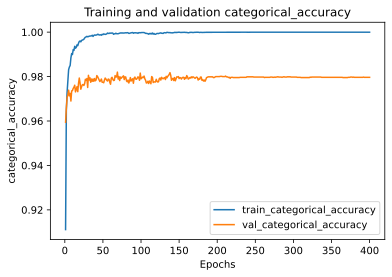

In [20]:
plot_metric(svm_history_noise, 'categorical_accuracy')

In [21]:
print(model_svm_noise.evaluate(test_data70, test_label))

313/313 [==============================] - 1s 2ms/step - loss: 0.1391 - categorical_accuracy: 0.9787
[0.13909678161144257, 0.9786999821662903]


In [22]:
model_svm = Sequential([
    Dense(512, input_shape=(70,), activation='relu'),
    # GaussianNoise(0.1),
    Dense(512, activation='relu'),
    Dense(10, activation='linear')
])

optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
model_svm.compile(loss='categorical_hinge', optimizer=optimizer, metrics=['categorical_accuracy'])
t0 = time()
svm_history = model_svm.fit(train_data70, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=2)
t1 = time()
print(t1-t0)

Epoch 1/400
170/170 - 1s - loss: 0.2477 - categorical_accuracy: 0.9137 - val_loss: 0.1142 - val_categorical_accuracy: 0.9553
Epoch 2/400
170/170 - 0s - loss: 0.0957 - categorical_accuracy: 0.9639 - val_loss: 0.0885 - val_categorical_accuracy: 0.9653
Epoch 3/400
170/170 - 0s - loss: 0.0725 - categorical_accuracy: 0.9730 - val_loss: 0.0840 - val_categorical_accuracy: 0.9676
Epoch 4/400
170/170 - 0s - loss: 0.0564 - categorical_accuracy: 0.9791 - val_loss: 0.0803 - val_categorical_accuracy: 0.9707
Epoch 5/400
170/170 - 0s - loss: 0.0516 - categorical_accuracy: 0.9814 - val_loss: 0.0779 - val_categorical_accuracy: 0.9734
Epoch 6/400
170/170 - 0s - loss: 0.0423 - categorical_accuracy: 0.9845 - val_loss: 0.0736 - val_categorical_accuracy: 0.9757
Epoch 7/400
170/170 - 0s - loss: 0.0353 - categorical_accuracy: 0.9873 - val_loss: 0.0820 - val_categorical_accuracy: 0.9741
Epoch 8/400
170/170 - 0s - loss: 0.0377 - categorical_accuracy: 0.9871 - val_loss: 0.0755 - val_categorical_accuracy: 0.9758


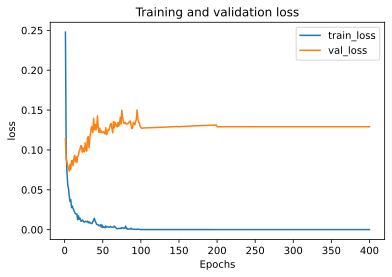

In [23]:
plot_metric(svm_history, 'loss')

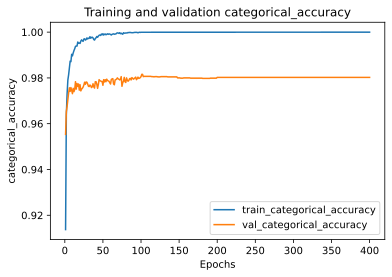

In [24]:
plot_metric(svm_history, 'categorical_accuracy')

In [25]:
print(model_svm.evaluate(test_data70, test_label))

313/313 [==============================] - 1s 2ms/step - loss: 0.1537 - categorical_accuracy: 0.9764
[0.1537424623966217, 0.9764000177383423]


In [26]:
model_svm_regularized = Sequential([
    Dense(512, input_shape=(70,), activation='relu'),
    # GaussianNoise(0.1),
    Dense(512, activation='relu'),
    Dense(10, kernel_regularizer=l2(1e-4),activation='linear')
])

optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
model_svm_regularized.compile(loss='categorical_hinge', optimizer=optimizer, metrics=['categorical_accuracy'])
t0 = time()
regularized_svm_history = model_svm_regularized.fit(train_data70, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=2)
t1 = time()
print(t1-t0)

Epoch 1/400
170/170 - 1s - loss: 0.2423 - categorical_accuracy: 0.9139 - val_loss: 0.1097 - val_categorical_accuracy: 0.9592
Epoch 2/400
170/170 - 0s - loss: 0.0960 - categorical_accuracy: 0.9652 - val_loss: 0.0952 - val_categorical_accuracy: 0.9663
Epoch 3/400
170/170 - 0s - loss: 0.0783 - categorical_accuracy: 0.9723 - val_loss: 0.0949 - val_categorical_accuracy: 0.9660
Epoch 4/400
170/170 - 0s - loss: 0.0630 - categorical_accuracy: 0.9782 - val_loss: 0.0852 - val_categorical_accuracy: 0.9717
Epoch 5/400
170/170 - 0s - loss: 0.0506 - categorical_accuracy: 0.9831 - val_loss: 0.0761 - val_categorical_accuracy: 0.9744
Epoch 6/400
170/170 - 0s - loss: 0.0448 - categorical_accuracy: 0.9850 - val_loss: 0.0823 - val_categorical_accuracy: 0.9742
Epoch 7/400
170/170 - 0s - loss: 0.0426 - categorical_accuracy: 0.9866 - val_loss: 0.0829 - val_categorical_accuracy: 0.9738
Epoch 8/400
170/170 - 0s - loss: 0.0355 - categorical_accuracy: 0.9888 - val_loss: 0.0784 - val_categorical_accuracy: 0.9750


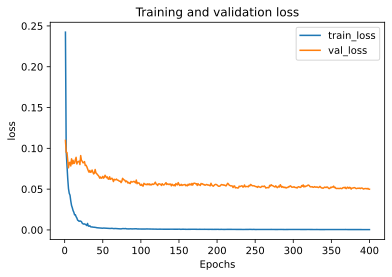

In [27]:
plot_metric(regularized_svm_history, 'loss')

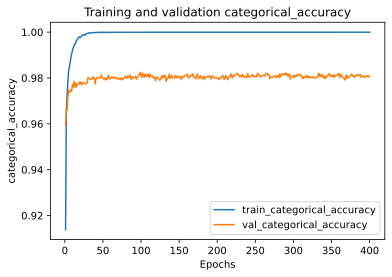

In [28]:
plot_metric(regularized_svm_history, 'categorical_accuracy')

In [29]:
print(model_svm_regularized.evaluate(test_data70, test_label))

313/313 [==============================] - 1s 2ms/step - loss: 0.0532 - categorical_accuracy: 0.9810
[0.05320147052407265, 0.9810000061988831]


Streaming output truncated to the last 5000 lines.
170/170 [==============================] - 1s 8ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1217 - val_categorical_accuracy: 0.9807
Epoch 305/400
170/170 [==============================] - 1s 7ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1217 - val_categorical_accuracy: 0.9803
Epoch 306/400
170/170 [==============================] - 1s 6ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1219 - val_categorical_accuracy: 0.9804
Epoch 307/400
170/170 [==============================] - 1s 6ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1219 - val_categorical_accuracy: 0.9807
Epoch 308/400
170/170 [==============================] - 1s 8ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - val_loss: 0.1217 - val_categorical_accuracy: 0.9806
Epoch 309/400
170/170 [==============================] - 1s 6ms/step - loss: 0.0011 - categorical_accuracy: 1.0000 - v

NameError: ignored

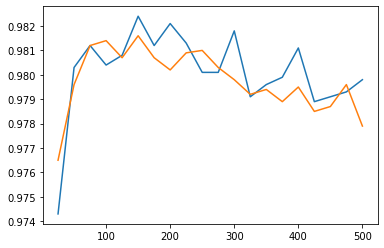

In [2]:
"""
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.linalg as linalg
from skcuda.linalg import PCA as cuPCA
"""
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import SGD
from time import time
from keras.layers import Dense
from tensorflow.keras.regularizers import l2
acc_list_svm = []
acc_list_soft = []
num_components_list = [i*25 for i in range(1, 21)]
for i in range(1, 21):
    pca = PCA(n_components=25*i) # map the data to 70 dimensions
    train_data_reduced = pca.fit_transform(train_data784_normalized)
    
    test_data_reduced = pca.transform(test_data784_normalized)

    model_svm_regularized = Sequential([
        Dense(512, input_shape=(25*i,), activation='relu'),
        # GaussianNoise(0.1), not good
        Dense(512, activation='relu'),
        Dense(10, kernel_regularizer=l2(1e-4),activation='linear')
    ])

    model_soft_regularized = Sequential([
        Dense(512, input_shape=(25*i,), activation='relu'),
        # GaussianNoise(0.1), not good
        Dense(512, activation='relu'),
        Dense(10, kernel_regularizer=l2(1e-4),activation='softmax')
    ])

    optimizer = SGD(lr=0.1, momentum=0.9, decay=1.0/(300*400), nesterov=False)
    model_svm_regularized.compile(loss='categorical_hinge', optimizer=optimizer, metrics=['categorical_accuracy'])
    model_svm_regularized.fit(train_data_reduced, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=1)
    acc = model_svm_regularized.evaluate(test_data_reduced, test_label)[1]
    acc_list_svm.append(acc)
    model_soft_regularized.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    model_soft_regularized.fit(train_data_reduced, train_label, epochs=400, batch_size=300, validation_split=0.15, verbose=1)
    acc_list_soft.append(model_soft_regularized.evaluate(test_data_reduced, test_label)[1])




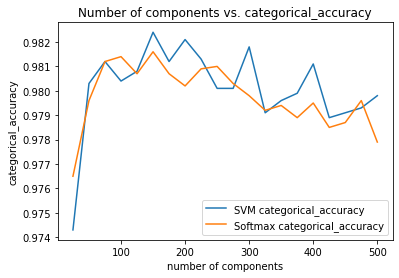

In [4]:
plt.plot(num_components_list, acc_list_svm)
plt.plot(num_components_list, acc_list_soft)
plt.title('Number of components vs. categorical_accuracy')
plt.xlabel("number of components")
plt.ylabel('categorical_accuracy')
plt.legend(["SVM categorical_accuracy", 'Softmax categorical_accuracy'])
plt.show()

In [5]:
print(acc_list_svm)
print(acc_list_soft)

[0.9743000268936157, 0.9803000092506409, 0.9811999797821045, 0.980400025844574, 0.9807999730110168, 0.9824000000953674, 0.9811999797821045, 0.9821000099182129, 0.9812999963760376, 0.9800999760627747, 0.9800999760627747, 0.9818000197410583, 0.9790999889373779, 0.9796000123023987, 0.9799000024795532, 0.9811000227928162, 0.9789000153541565, 0.9790999889373779, 0.9793000221252441, 0.9797999858856201]
[0.9764999747276306, 0.9796000123023987, 0.9811999797821045, 0.9814000129699707, 0.9807000160217285, 0.9815999865531921, 0.9807000160217285, 0.9801999926567078, 0.98089998960495, 0.9810000061988831, 0.9803000092506409, 0.9797999858856201, 0.979200005531311, 0.9793999791145325, 0.9789000153541565, 0.9794999957084656, 0.9785000085830688, 0.9786999821662903, 0.9796000123023987, 0.9779000282287598]
